In [49]:
import tensorflow as tf
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [121]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from matplotlib import pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

plt.rcParams["figure.figsize"] = [16, 12]

print("pandas Version: " + pd.__version__)
print("numpy Version: " + np.__version__)
print("statsmodels Version: " + sm.__version__)

pandas Version: 1.2.4
numpy Version: 1.18.5
statsmodels Version: 0.12.2


In [124]:
# Make cells wider and figures larger
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:70% !important; }</style>"))
plt.rcParams["figure.figsize"] = (16,8)

In [52]:
# Switch between recalculating or reading from file to save time

READ_ADF_RESULTS_FROM_FILE = False

In [53]:
df = pd.read_csv("../data/clean/station_trips_weather.csv", parse_dates=["datetime"])
df.set_index("datetime", inplace=True)
df["station_name"] = df["station_name"].astype("category")

In [54]:
df.head(3)

station_name  check_ins  check_outs  \
datetime                                                                    
2014-01-01                Allende-Platz/Grindelhof          0           5   
2014-01-01                Alsenstraße/Düppelstraße          3           0   
2014-01-01  Alsterdorf Markt/Evangelische Stiftung          0           0   

            diff  precip_intensity  precip_probability precip_type  \
datetime                                                             
2014-01-01    -5               0.0                 0.0        none   
2014-01-01     3               0.0                 0.0        none   
2014-01-01     0               0.0                 0.0        none   

            temperature  humidity  wind_speed  wind_bearing  uv_index  \
datetime                                                                
2014-01-01         1.93      0.81        3.91         161.0       0.0   
2014-01-01         1.93      0.81        3.91         161.0       0.0   
2014-01-01         1.93      0.81        3.91         161.0       0.0   

            visibility  
datetime                
2014-01-01       9.988  
2014-01-01       9.988  
2014-01-01       9.988

In [55]:
df.tail(3)

station_name  check_ins  check_outs  \
datetime                                                                     
2017-05-15 11:00:00   Winterhuder Weg/ Zimmerstraße          2           4   
2017-05-15 11:00:00  Zentralbibliothek / Münzstraße          0           2   
2017-05-15 11:00:00          Überseering/Mexikoring          1           1   

                     diff  precip_intensity  precip_probability precip_type  \
datetime                                                                      
2017-05-15 11:00:00    -2               0.0                 0.0        none   
2017-05-15 11:00:00    -2               0.0                 0.0        none   
2017-05-15 11:00:00     0               0.0                 0.0        none   

                     temperature  humidity  wind_speed  wind_bearing  \
datetime                                                               
2017-05-15 11:00:00        14.02      0.71        3.49         276.0   
2017-05-15 11:00:00        14.02      0.71        3.49         276.0   
2017-05-15 11:00:00        14.02      0.71        3.49         276.0   

                     uv_index  visibility  
datetime                                   
2017-05-15 11:00:00       4.0      10.003  
2017-05-15 11:00:00       4.0      10.003  
2017-05-15 11:00:00       4.0      10.003

In [56]:
stations = pd.read_csv("../data/clean/stations.csv")
stations.sample(3)

station_id                             name  longitude   latitude
114      213832    Domstraße/Willy-Brandt-Straße   9.994057  53.547486
50       138387  Mönckebergstraße / Steintorwall  10.005400  53.551600
25       131881     Universität / Schlüterstraße   9.986076  53.566972

In [59]:
sample_station_a = "Am Kaiserkai/Großer Grasbrook"
sample_station_b = "Grindelberg / Bezirksamt Eimsbüttel"
sample_station_c = "Barkassenanleger/Mengestraße"
sample_stations = [sample_station_a, sample_station_b, sample_station_c]

sample_df_a = df[df.station_name == sample_station_a][["station_name", "check_ins"]]
sample_df_b = df[df.station_name == sample_station_b][["station_name", "check_ins"]]
sample_df_c = df[df.station_name == sample_station_c][["station_name", "check_ins"]]
sample_stations_dfs = [sample_df_a, sample_df_b, sample_df_c]

## Building an ARIMA model

### Examine stationarity

In [60]:
#title = "Difference of check-in and check-out: {name}"
fig = make_subplots(
    rows=3, 
    cols=1, 
    shared_yaxes=True, 
    x_title="Date",
    y_title="Hourly check-in values"
)

row = 1
for sample_slice in sample_stations_dfs:
    trace = go.Scatter(
        x=sample_slice.index,
        y=sample_slice["check_ins"],
        mode="lines",
        name=pd.unique(sample_slice.station_name)[0]
    )
    fig.append_trace(trace, row=row, col=1)
    row = row + 1

fig.show()

Looks stationary.

**Check if the data is stationary with an ADF test**

1. Test stationarity with the *Augmented Dickey-Fuller* test for every sample station
2. Collect the results in a dataframe with columns for 'ADF statistics', 'ADF p_value', 'ADF critvalue 1'
3. Add a 'stationary' column and set to True, if 'p_value' is lower than the threshold of 0.05 and the 'ADF statistics' value is negative and lower than the 'ADF critvalue 1' value, otherwise set to False

In [61]:
p_threshold = 0.05

def is_stationary(stats, p_value, crit1):
    return (
        p_value < p_threshold
    ) and (
        (stats < 0) and (stats < crit1)
    )

In [62]:
check_ins_adf_results = pd.DataFrame([], columns=["station_name", "stats", "p_value", "crit1"])

for station in sample_stations:
    df_tmp = df[df.station_name == station]
    result = adfuller(df_tmp["check_ins"])
    check_ins_adf_results = check_ins_adf_results.append({
        "station_name": station,
        "stats": result[0],
        "p_value": result[1],
        "crit1": result[4]["1%"]
    }, ignore_index=True)
    
check_ins_adf_results["stationary"] = check_ins_adf_results.apply(
    lambda x: is_stationary(x["stats"], x["p_value"], x["crit1"]), 
    axis=1
)

check_ins_adf_results

station_name      stats       p_value     crit1  \
0        Am Kaiserkai/Großer Grasbrook -19.748279  0.000000e+00 -3.430572   
1  Grindelberg / Bezirksamt Eimsbüttel -10.833728  1.682600e-19 -3.430572   
2         Barkassenanleger/Mengestraße -11.272748  1.522569e-20 -3.430572   

   stationary  
0        True  
1        True  
2        True

The check-in data is stationary for the selected stations and therefore does not require differenciation when predicting with an ARIMA model. Therefore the `d` parameter can be set to 0.

## Exploration

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

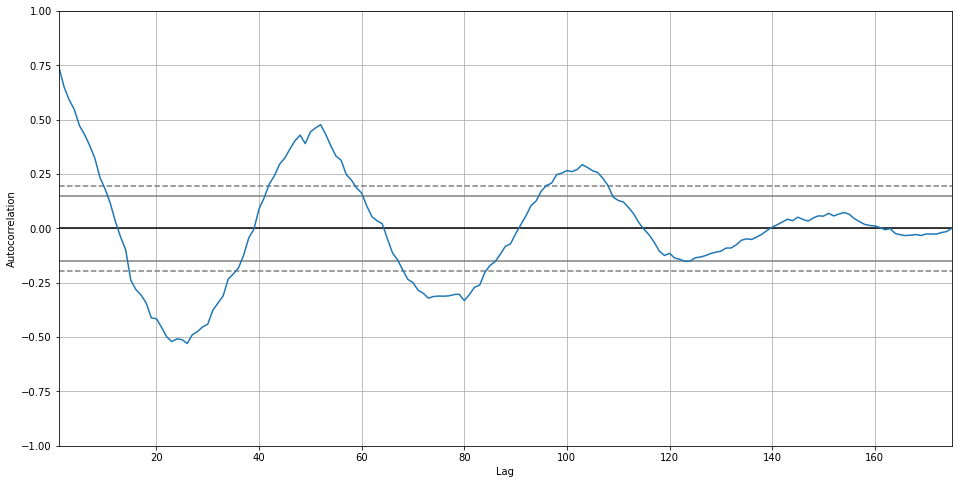

In [125]:
autocorrelation_plot(weekly_sample.check_ins)

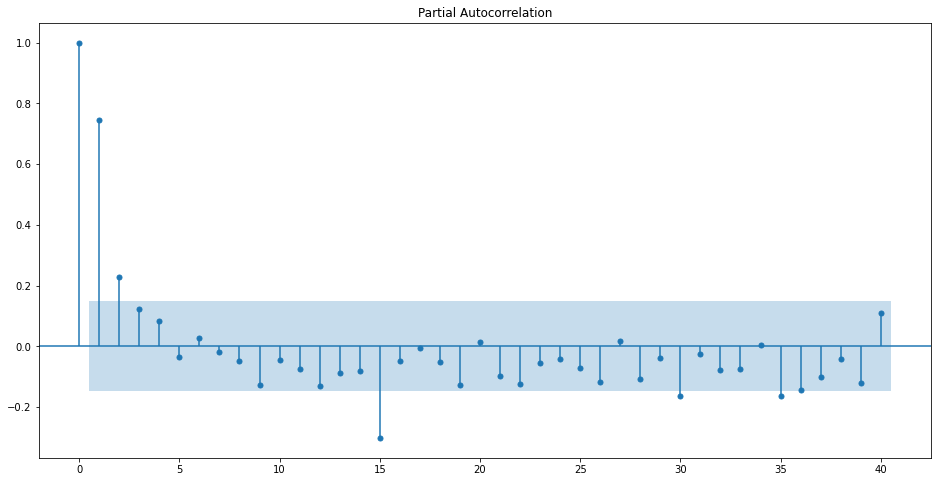

In [132]:
plot_pacf(weekly_sample.check_ins, lags=40) # p
plt.show()

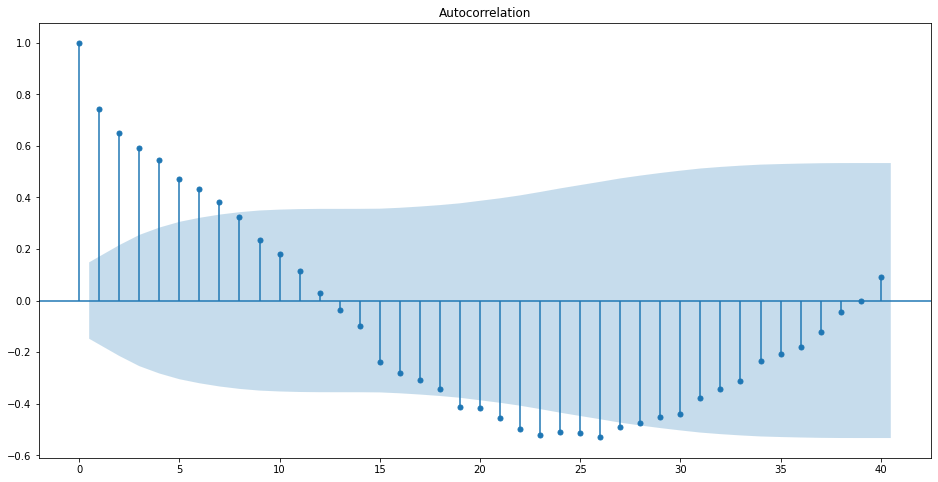

In [127]:
plot_acf(weekly_sample.check_ins, lags=40) # q
plt.show()

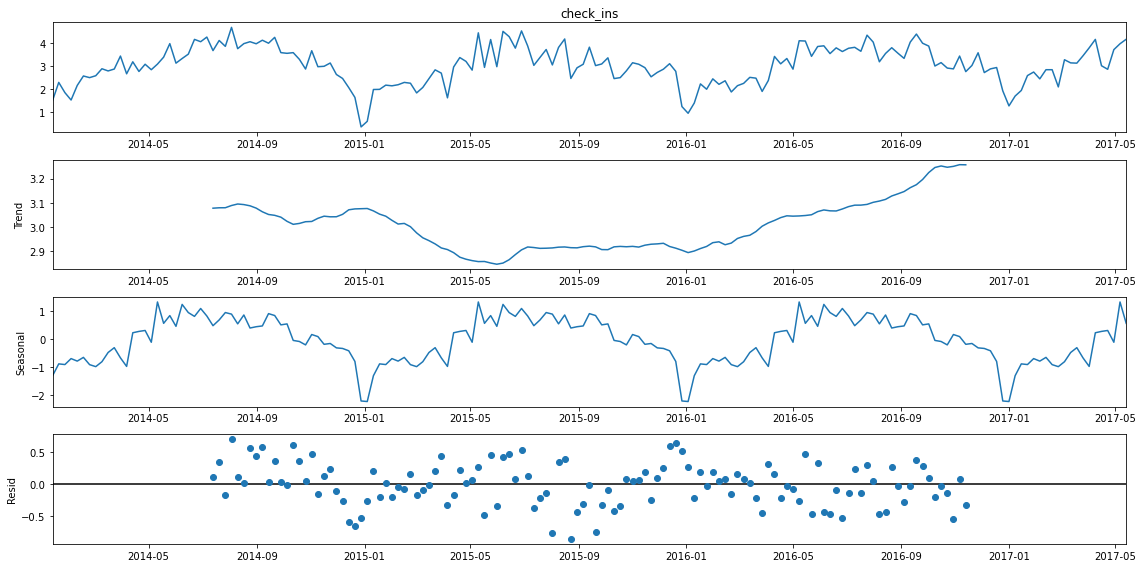

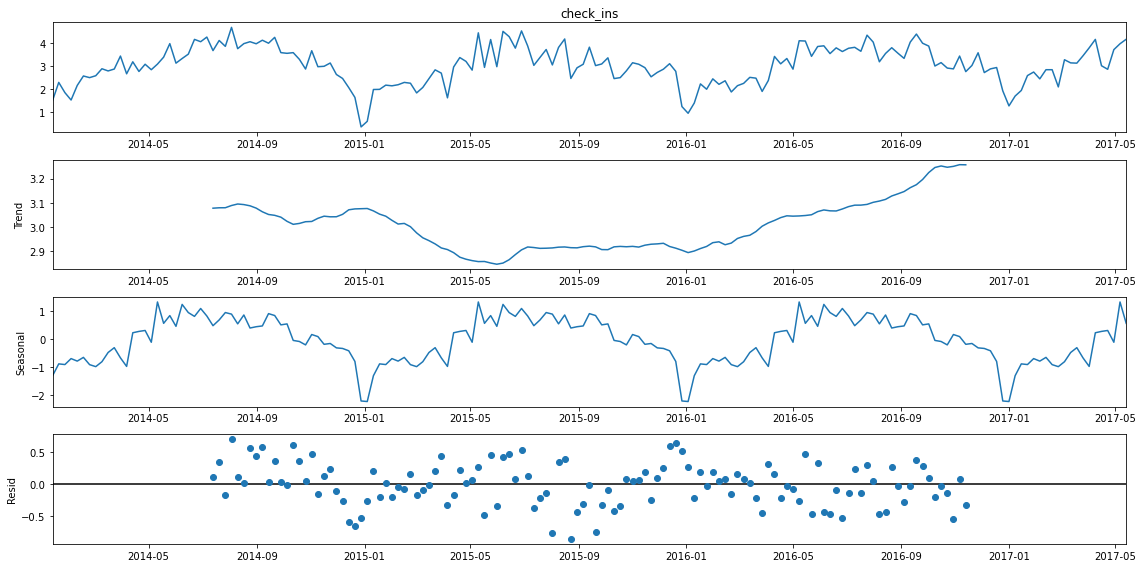

In [130]:
seasonal_decompose(weekly_sample.check_ins, freq=None).plot()

In [69]:
sample_station_df = sample_df_a
#sample_station_df = df[["check_ins"]].resample("H").sum()
train_size = 0.9
test_size = 0.1

## Monthly prediction

<AxesSubplot:xlabel='datetime'>

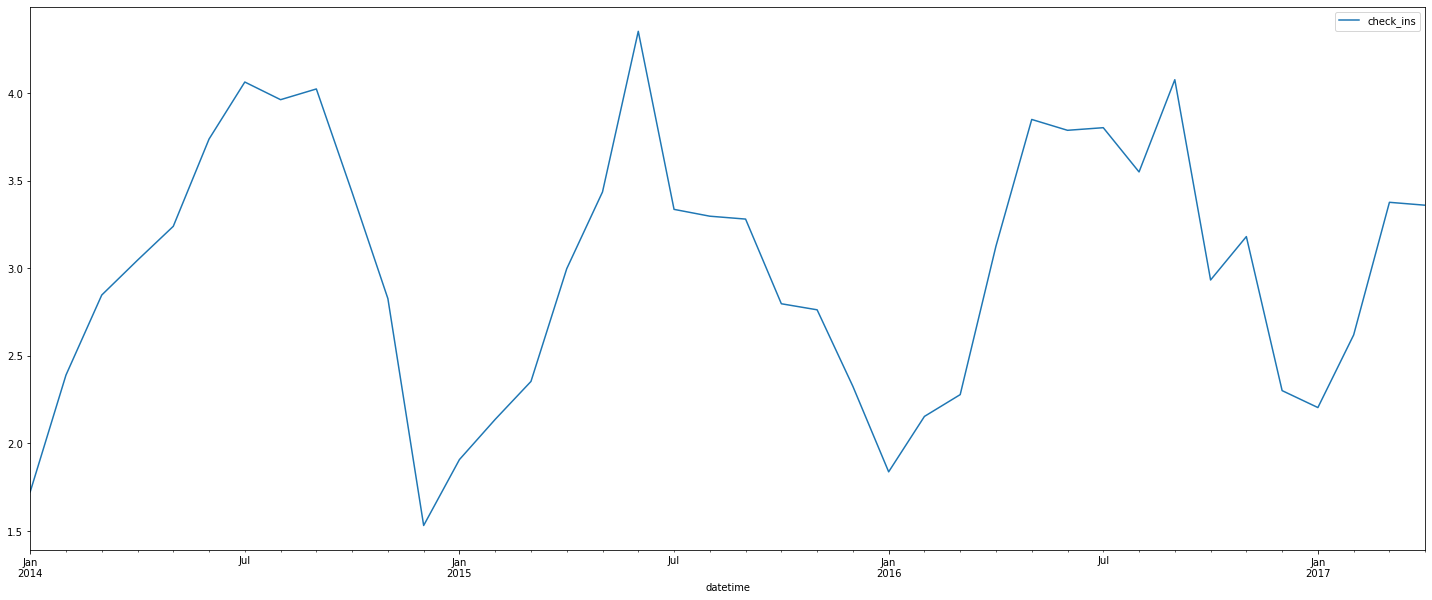

In [70]:
monthly_start_date = "2014-01-01"
monthly_end_date = "2017-04-30 23:59:59"
monthly_sample = sample_station_df[
    pd.Timestamp(monthly_start_date):pd.Timestamp(monthly_end_date)
].resample("M").mean()
monthly_sample.plot()

In [71]:
monthly_train, monthly_test = train_test_split(
    monthly_sample, shuffle=False, train_size=train_size, test_size=test_size
)

monthly_auto = auto_arima(
    y = monthly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    m = 12
)

monthly_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -21.218
Date:                              Fri, 14 May 2021   AIC                             52.437
Time:                                      17:29:31   BIC                             60.354
Sample:                                           0   HQIC                            55.200
                                               - 36                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0397      0.386      0.103      0.918      -0.717       0.797
ar.L1          0.5219      0.204      2.562      0.010       0.123       0.921
ar.S.L12       0.9723      0.266      3.652      0.000       0.450       1.494
ma.S.L12      -0.7133      1.297     -0.550      0.582      -3.255       1.828
sigma2         0.1272      0.122      1.044      0.296      -0.112       0.366
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.75   Prob(JB):                         0.50
Heteroskedasticity (H):               0.78   Skew:                            -0.40
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

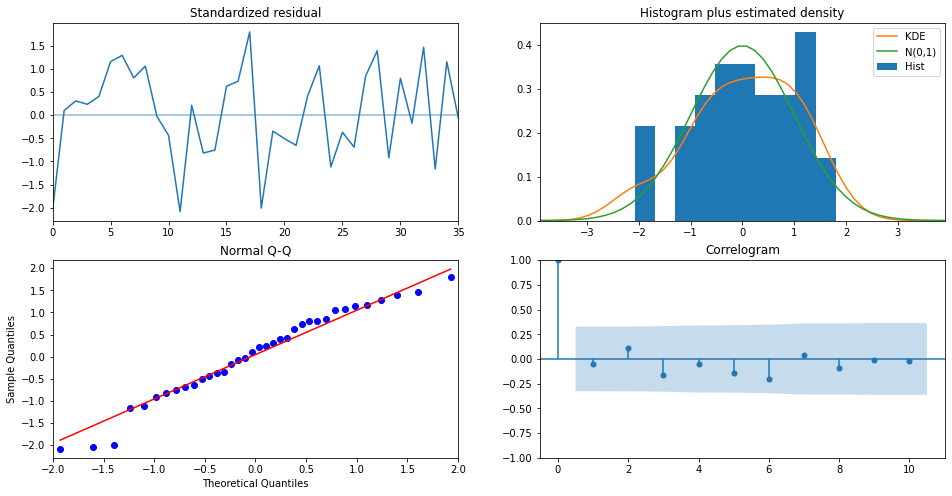

In [72]:
monthly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [73]:
monthly_order = monthly_auto.get_params()["order"]
monthly_seasonal_order = monthly_auto.get_params()["seasonal_order"]
print("Order " + str(monthly_order))
print("Order " + str(monthly_seasonal_order))

Order (1, 0, 0)
Order (1, 0, 1, 12)


In [74]:
monthly_arima = ARIMA(monthly_train, order=monthly_order)
monthly_arima_fit = monthly_arima.fit()
monthly_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                   36
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -27.784
Date:                Fri, 14 May 2021   AIC                             61.567
Time:                        17:29:53   BIC                             66.318
Sample:                    01-31-2014   HQIC                            63.225
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8831      0.303      9.510      0.000       2.289       3.477
ar.L1          0.7373      0.136      5.424      0.000       0.471       1.004
sigma2         0.2682      0.071      3.788      0.000       0.129       0.407
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.48   Prob(JB):                         0.48
Heteroskedasticity (H):               0.93   Skew:                            -0.49
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.22370137875613927


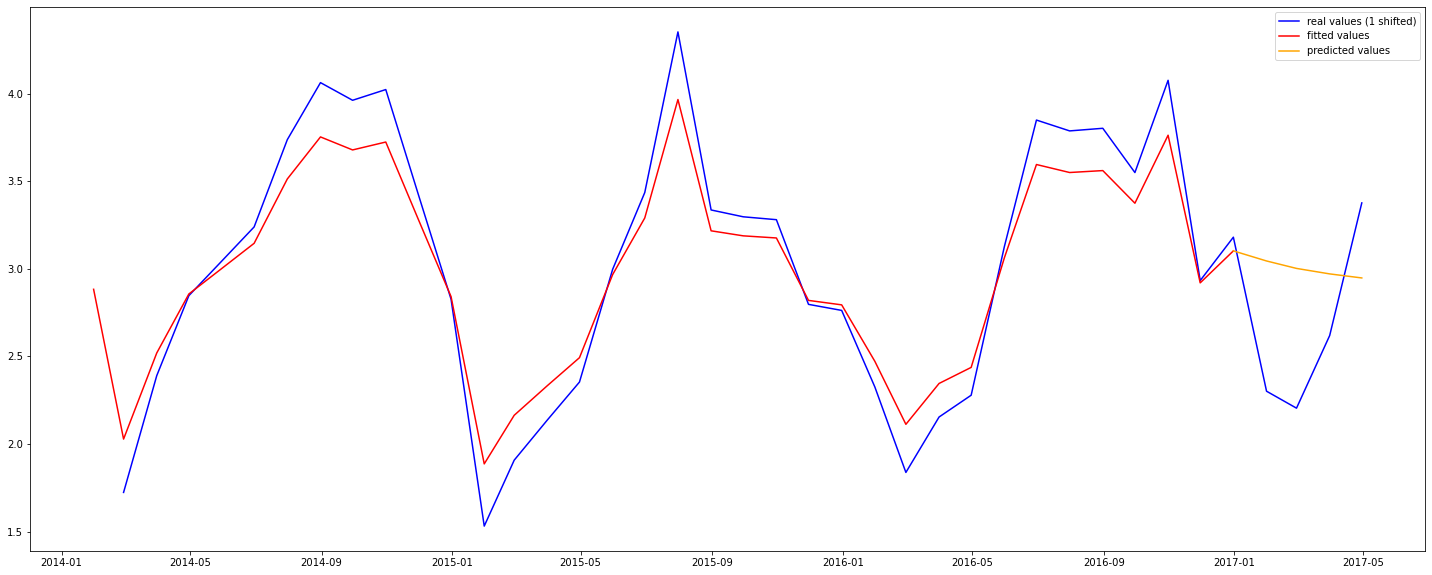

In [75]:
monthly_arima_predictions = monthly_arima_fit.predict(
    start=monthly_train.index.max(), end=monthly_test.index.max(), dynamic=True
).to_frame()
mape = mean_absolute_percentage_error(
    monthly_sample.loc[monthly_arima_predictions.index], monthly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(monthly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(monthly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(monthly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [76]:
monthly_sarimax = SARIMAX(monthly_train, order=monthly_order, seasonal_order=monthly_seasonal_order)
monthly_sarimax_fit = monthly_sarimax.fit()
monthly_sarimax_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            check_ins   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -26.347
Date:                              Fri, 14 May 2021   AIC                             60.694
Time:                                      17:30:06   BIC                             67.028
Sample:                                  01-31-2014   HQIC                            62.904
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9460      0.060     15.695      0.000       0.828       1.064
ar.S.L12       0.9990      0.300      3.332      0.001       0.411       1.587
ma.S.L12      -0.9509      6.933     -0.137      0.891     -14.538      12.637
sigma2         0.1481      0.962      0.154      0.878      -1.737       2.033
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 4.73
Prob(Q):                              0.43   Prob(JB):                         0.09
Heteroskedasticity (H):               1.06   Skew:                            -0.89
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.0886090284062646


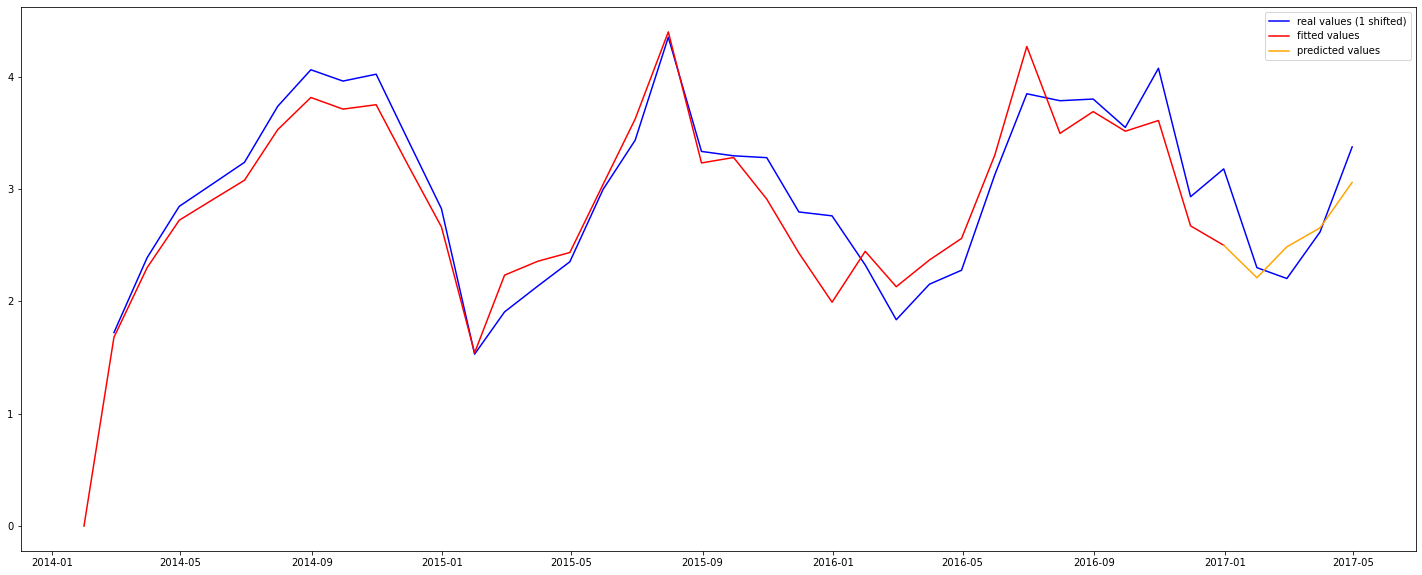

In [77]:
monthly_sarimax_predictions = monthly_sarimax_fit.predict(
    start=monthly_train.index.max(), end=monthly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    monthly_sample.loc[monthly_sarimax_predictions.index], monthly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(monthly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(monthly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(monthly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

## Weekly prediction

In [78]:
sample_station_df.index.min() # Wednesday

Timestamp('2014-01-01 00:00:00')

In [79]:
sample_station_df.index.max() # Monday

Timestamp('2017-05-15 11:00:00')

<AxesSubplot:xlabel='datetime'>

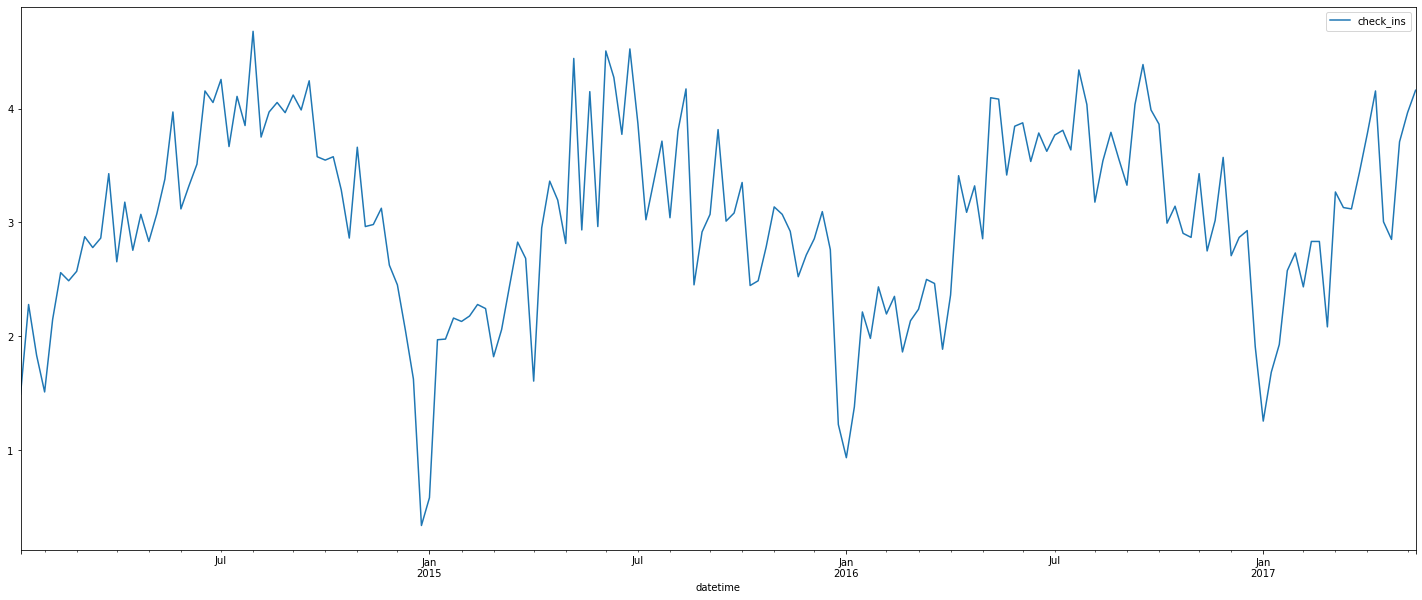

In [80]:
weekly_start_date = "2014-01-07" # first Sunday morning
weekly_end_date = "2017-05-14 23:59:59" # last Monday evening
weekly_sample = sample_station_df[pd.Timestamp(weekly_start_date):pd.Timestamp(weekly_end_date)].resample("W").mean()
weekly_sample.plot()

In [81]:
weekly_train, weekly_test = train_test_split(weekly_sample, shuffle=False, train_size=train_size, test_size=test_size)

weekly_auto = auto_arima(
    y = weekly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    trace = True,
    m = 52
)

weekly_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=8.22 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=394.584, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=255.006, Time=7.20 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=302.592, Time=1.70 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=806.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=261.975, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=25.78 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.14 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=256.699, Time=1.95 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=75.37 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=246.276, Time=6.78 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=253.980, Time=0.03 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=25.40 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  157
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 52)   Log Likelihood                -115.241
Date:                            Fri, 14 May 2021   AIC                            242.481
Time:                                    17:38:41   BIC                            260.819
Sample:                                         0   HQIC                           249.929
                                            - 157                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3542      0.145      2.440      0.015       0.070       0.639
ar.L1          0.4612      0.073      6.351      0.000       0.319       0.604
ar.L2          0.1601      0.077      2.076      0.038       0.009       0.311
ar.L3          0.1972      0.087      2.268      0.023       0.027       0.368
ar.S.L52       0.3375      0.077      4.407      0.000       0.187       0.488
sigma2         0.2427      0.028      8.803      0.000       0.189       0.297
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.65   Prob(JB):                         0.51
Heteroskedasticity (H):               0.89   Skew:                            -0.15
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

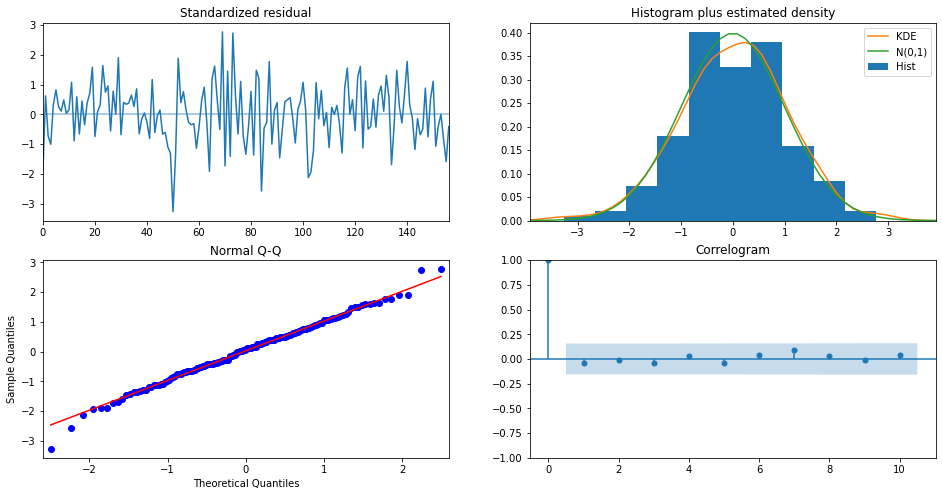

In [82]:
weekly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [83]:
weekly_order = weekly_auto.get_params()["order"]
weekly_seasonal_order = weekly_auto.get_params()["seasonal_order"]
print("Order " + str(weekly_order))
print("Seasonal order " + str(weekly_seasonal_order))

Order (3, 0, 0)
Seasonal order (1, 0, 0, 52)


In [133]:
weekly_arima = ARIMA(weekly_train, order=weekly_order)
weekly_arima_fit = weekly_arima.fit()
weekly_arima_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                  157
Model:                 ARIMA(3, 0, 8)   Log Likelihood                -108.593
Date:                Fri, 14 May 2021   AIC                            243.186
Time:                        18:07:03   BIC                            282.917
Sample:                    01-12-2014   HQIC                           259.323
                         - 01-08-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9822      0.029    102.921      0.000       2.925       3.039
ar.L1          0.9839      0.358      2.745      0.006       0.281       1.686
ar.L2          0.9811      0.711      1.380      0.168      -0.412       2.374
ar.L3         -0.9914      0.357     -2.773      0.006      -1.692      -0.291
ma.L1         -0.6206      0.401     -1.549      0.121      -1.406       0.165
ma.L2         -1.1323      0.635     -1.783      0.075      -2.377       0.112
ma.L3          0.5769      0.244      2.362      0.018       0.098       1.056
ma.L4          0.1704      0.162      1.051      0.293      -0.147       0.488
ma.L5         -0.0733      0.153     -0.479      0.632      -0.373       0.226
ma.L6          0.0651      0.154      0.422      0.673      -0.238       0.368
ma.L7          0.1217      0.106      1.149      0.250      -0.086       0.329
ma.L8         -0.0925      0.095     -0.968      0.333      -0.280       0.095
sigma2         0.2257      0.030      7.542      0.000       0.167       0.284
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.09
Prob(Q):                              0.93   Prob(JB):                         0.03
Heteroskedasticity (H):               0.95   Skew:                            -0.42
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.26518424380043504


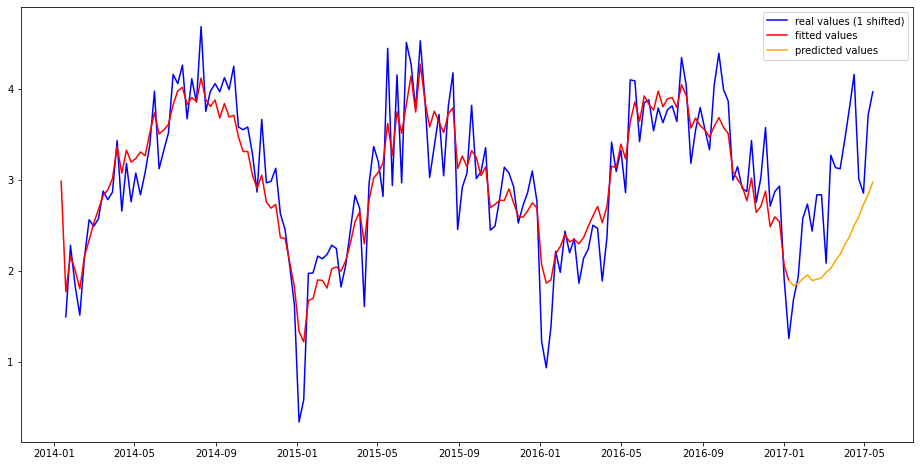

In [134]:
weekly_arima_predictions = weekly_arima_fit.predict(
    start=weekly_train.index.max(), end=weekly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    weekly_sample.loc[weekly_arima_predictions.index], weekly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(weekly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(weekly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(weekly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [135]:
weekly_sarimax = SARIMAX(weekly_train, order=weekly_order, seasonal_order=weekly_seasonal_order)
weekly_sarimax_fit = weekly_sarimax.fit()
weekly_sarimax_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           check_ins   No. Observations:                  157
Model:             SARIMAX(3, 0, 8)x(1, 0, [], 52)   Log Likelihood                -115.667
Date:                             Fri, 14 May 2021   AIC                            257.334
Time:                                     18:07:44   BIC                            297.065
Sample:                                 01-12-2014   HQIC                           273.470
                                      - 01-08-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4084      0.063      6.481      0.000       0.285       0.532
ar.L2         -0.3127      0.072     -4.368      0.000      -0.453      -0.172
ar.L3          0.8992      0.071     12.629      0.000       0.760       1.039
ma.L1          0.1015      0.094      1.078      0.281      -0.083       0.286
ma.L2          0.5534      0.099      5.595      0.000       0.360       0.747
ma.L3         -0.4985      0.100     -4.977      0.000      -0.695      -0.302
ma.L4         -0.0242      0.093     -0.260      0.795      -0.206       0.158
ma.L5         -0.0225      0.103     -0.220      0.826      -0.224       0.179
ma.L6          0.0343      0.113      0.305      0.761      -0.186       0.255
ma.L7          0.0370      0.104      0.356      0.722      -0.167       0.241
ma.L8          0.1472      0.096      1.525      0.127      -0.042       0.336
ar.S.L52       0.3115      0.082      3.788      0.000       0.150       0.473
sigma2         0.2342      0.031      7.528      0.000       0.173       0.295
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.95   Prob(JB):                         0.26
Heteroskedasticity (H):               0.95   Skew:                            -0.29
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.29519694639679533


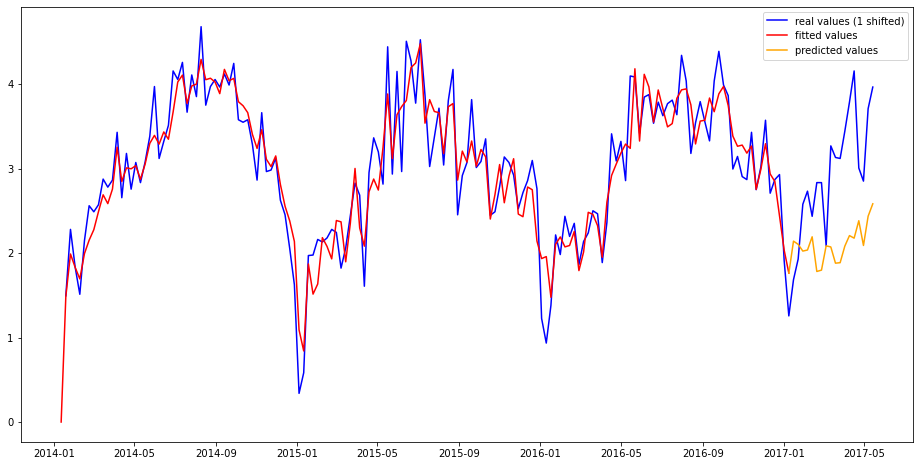

In [136]:
weekly_sarimax_predictions = weekly_sarimax_fit.predict(
    start=weekly_train.index.max(), end=weekly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    weekly_sample.loc[weekly_sarimax_predictions.index], weekly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(weekly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(weekly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(weekly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

## Daily predictions

<AxesSubplot:xlabel='datetime'>

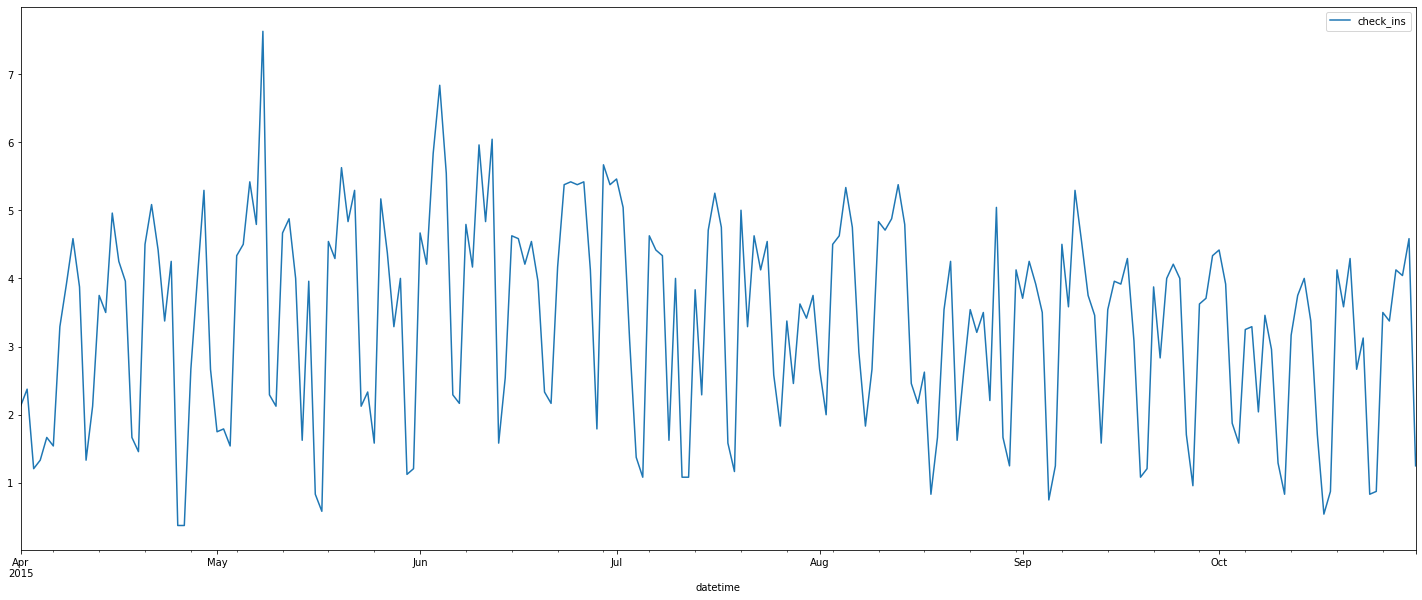

In [93]:
daily_start_date = "2015-04-01"
daily_end_date = "2015-10-31 23:59:59"
daily_sample = sample_station_df[pd.Timestamp(daily_start_date):pd.Timestamp(daily_end_date)].resample("D").mean()
daily_sample.plot()

In [95]:
daily_train, daily_test = train_test_split(
    daily_sample, shuffle=False, train_size=train_size, test_size=test_size
)

daily_auto = auto_arima(
    y = daily_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    m = 31
)

daily_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 31)   Log Likelihood                -328.989
Date:                            Fri, 14 May 2021   AIC                            665.977
Time:                                    17:44:23   BIC                            679.007
Sample:                                         0   HQIC                           671.255
                                            - 192                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4450      0.114     30.337      0.000       3.222       3.668
ma.L1          0.3706      0.071      5.252      0.000       0.232       0.509
ma.S.L31      -0.1910      0.079     -2.416      0.016      -0.346      -0.036
sigma2         1.7902      0.222      8.052      0.000       1.354       2.226
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.97   Prob(JB):                         0.36
Heteroskedasticity (H):               0.66   Skew:                            -0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

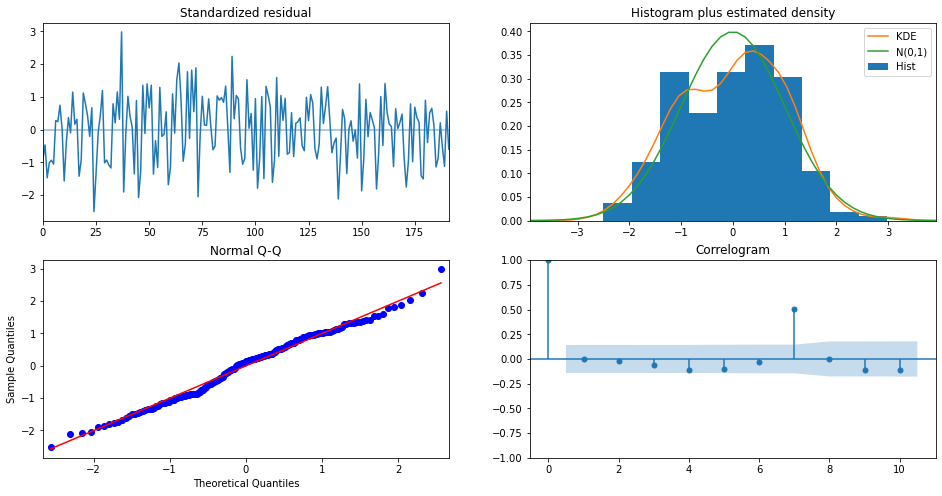

In [96]:
daily_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [97]:
daily_order = daily_auto.get_params()["order"]
daily_seasonal_order = daily_auto.get_params()["seasonal_order"]
print("Order " + str(daily_order))
print("Seasonal order " + str(daily_seasonal_order))

Order (0, 0, 1)
Seasonal order (0, 0, 1, 31)


In [98]:
daily_arima = ARIMA(daily_train, order=daily_order)
daily_arima_fit = daily_arima.fit()
daily_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                  192
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -331.595
Date:                Fri, 14 May 2021   AIC                            669.190
Time:                        17:44:50   BIC                            678.962
Sample:                    04-01-2015   HQIC                           673.148
                         - 10-09-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4225      0.137     24.948      0.000       3.154       3.691
ma.L1          0.3905      0.071      5.475      0.000       0.251       0.530
sigma2         1.8504      0.239      7.731      0.000       1.381       2.320
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.79   Prob(JB):                         0.29
Heteroskedasticity (H):               0.59   Skew:                            -0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 1.022025816704693


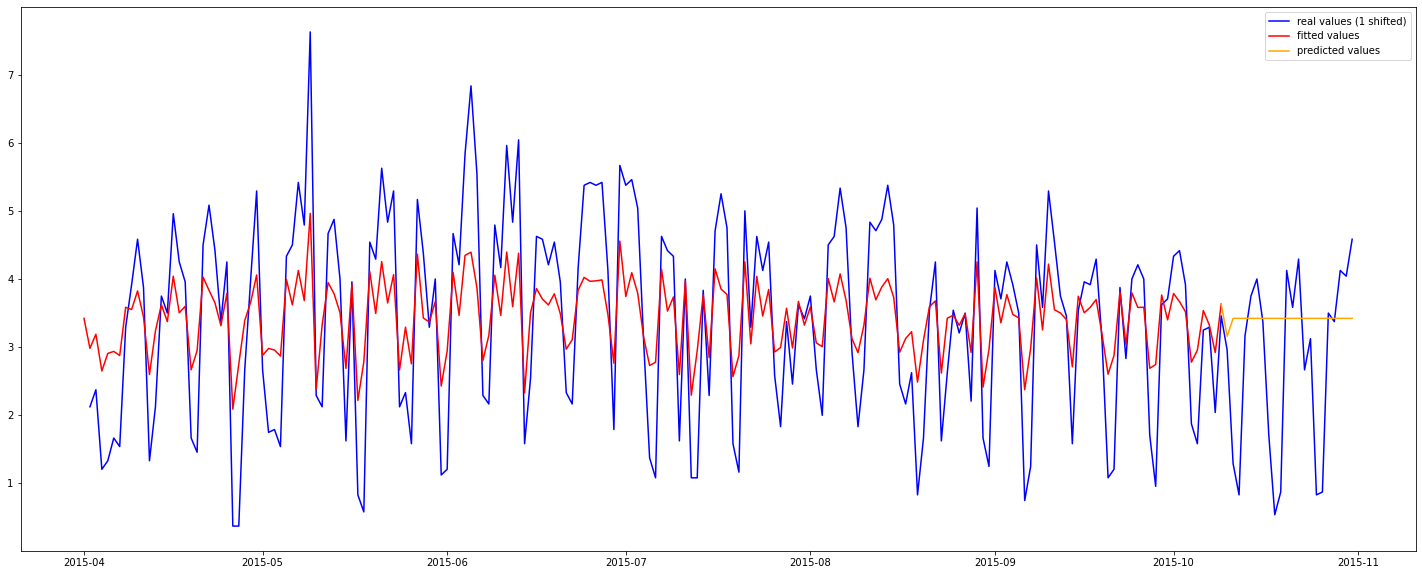

In [100]:
daily_arima_predictions = daily_arima_fit.predict(
    start=daily_train.index.max(), end=daily_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    daily_sample.loc[daily_arima_predictions.index], daily_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(daily_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(daily_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(daily_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [101]:
daily_sarimax = SARIMAX(daily_train, order=daily_order, seasonal_order=daily_seasonal_order)
daily_sarimax_fit = daily_sarimax.fit()
daily_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          check_ins   No. Observations:                  192
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 31)   Log Likelihood                -425.289
Date:                            Fri, 14 May 2021   AIC                            856.577
Time:                                    17:45:22   BIC                            866.350
Sample:                                04-01-2015   HQIC                           860.535
                                     - 10-09-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6989      0.058     11.956      0.000       0.584       0.813
ma.S.L31       0.4342      0.083      5.254      0.000       0.272       0.596
sigma2         4.7350      0.629      7.527      0.000       3.502       5.968
===================================================================================
Ljung-Box (L1) (Q):                  10.54   Jarque-Bera (JB):                 8.34
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.68   Skew:                            -0.43
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.7381910066900995


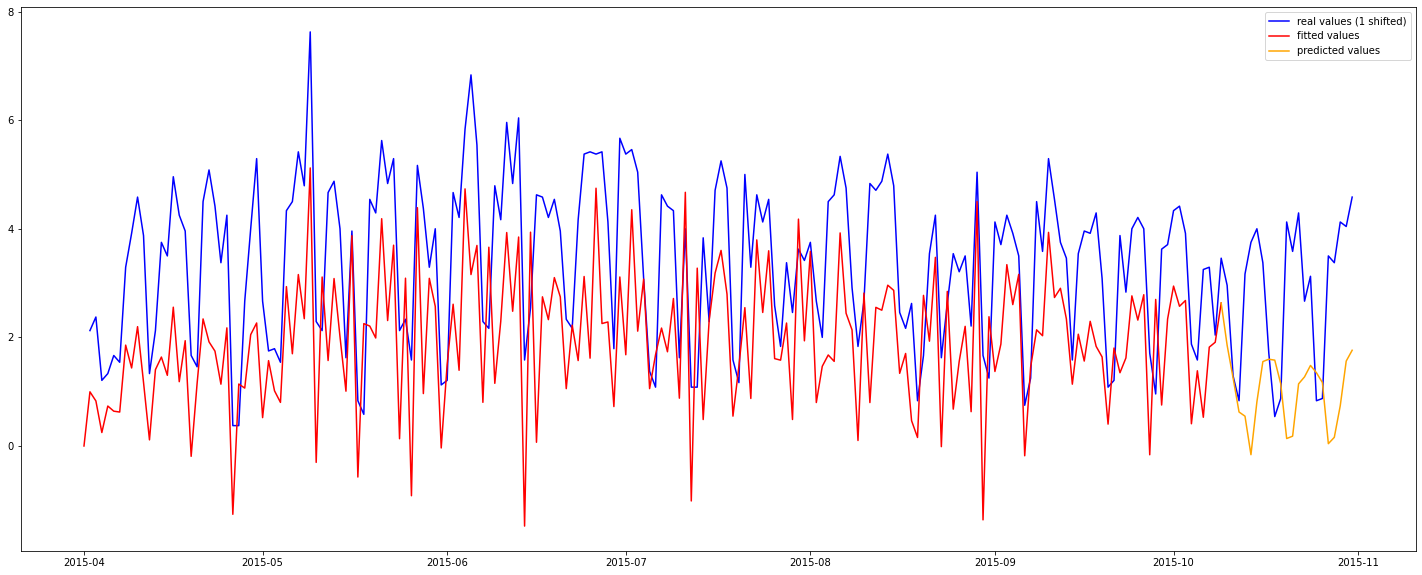

In [102]:
daily_sarimax_predictions = daily_sarimax_fit.predict(
    start=daily_train.index.max(), end=daily_test.index.max(), dynamic=True
).to_frame()
mape = mean_absolute_percentage_error(
    daily_sample.loc[daily_sarimax_predictions.index], daily_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(daily_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(daily_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(daily_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

## Hourly predictions

<AxesSubplot:xlabel='datetime'>

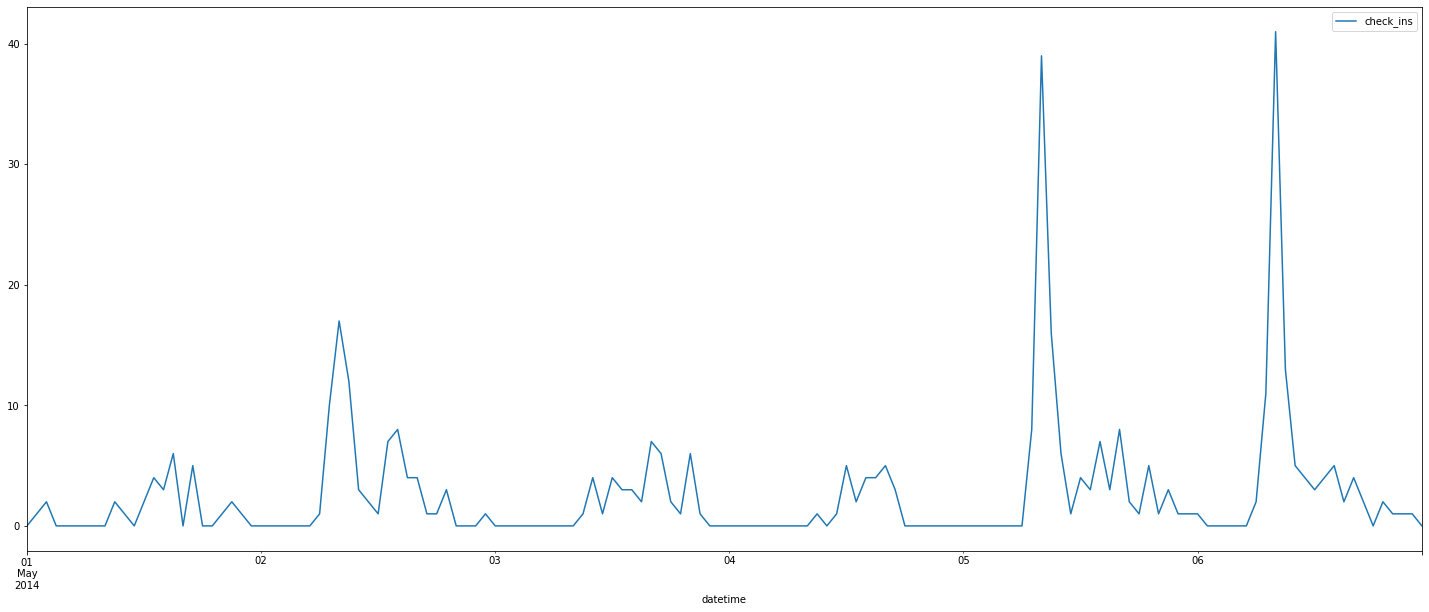

In [103]:
hourly_start_date = "2014-05-01"
hourly_end_date = "2014-05-06 23:59:59"
hourly_sample = sample_station_df[pd.Timestamp(hourly_start_date):pd.Timestamp(hourly_end_date)]
hourly_sample.plot()

In [104]:
hourly_train, hourly_test = train_test_split(
    hourly_sample, shuffle=False, train_size=train_size, test_size=test_size
)

hourly_auto = auto_arima(
    y = hourly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    m = 24
)

hourly_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  129
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                -369.502
Date:                            Fri, 14 May 2021   AIC                            751.004
Time:                                    17:46:46   BIC                            768.163
Sample:                                         0   HQIC                           757.976
                                            - 129                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8425      0.732      1.152      0.250      -0.591       2.276
ar.L1          0.6193      0.062      9.972      0.000       0.498       0.741
ar.L2         -0.1386      0.172     -0.805      0.421      -0.476       0.199
ar.S.L24       0.5901      0.040     14.917      0.000       0.513       0.668
ar.S.L48      -0.1679      0.313     -0.537      0.591      -0.781       0.445
sigma2        16.8162      0.934     18.007      0.000      14.986      18.647
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5871.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.55   Skew:                             4.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

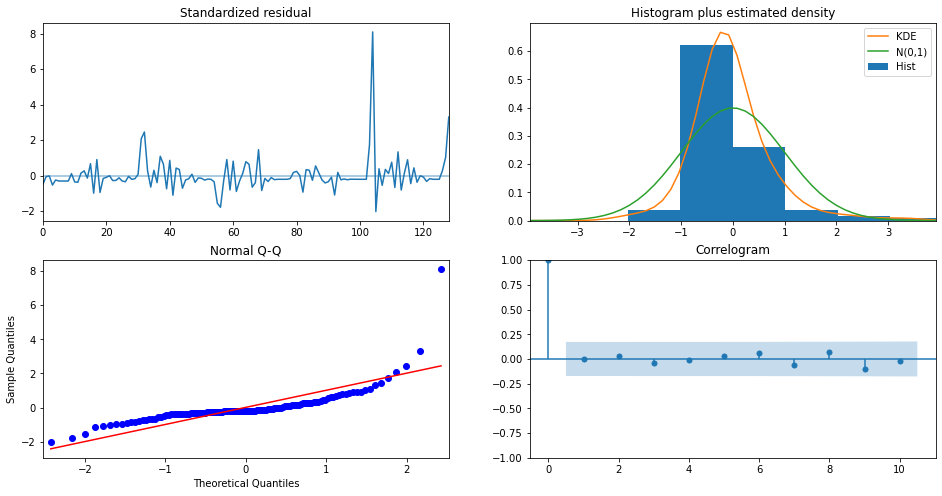

In [105]:
hourly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [106]:
hourly_order = hourly_auto.get_params()["order"]
hourly_seasonal_order = hourly_auto.get_params()["seasonal_order"]
print("Order " + str(hourly_order))
print("Seasonal order " + str(hourly_seasonal_order))

Order (2, 0, 0)
Seasonal order (2, 0, 0, 24)


In [107]:
hourly_arima = ARIMA(hourly_train, order=hourly_order)
hourly_arima_fit = hourly_arima.fit()
hourly_arima_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                  129
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -385.483
Date:                Fri, 14 May 2021   AIC                            778.966
Time:                        17:46:47   BIC                            790.405
Sample:                    05-01-2014   HQIC                           783.614
                         - 05-06-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8695      1.885      1.523      0.128      -0.824       6.563
ar.L1          0.7336      0.067     10.868      0.000       0.601       0.866
ar.L2         -0.2150      0.241     -0.892      0.372      -0.687       0.257
sigma2        22.9734      1.579     14.550      0.000      19.879      26.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4636.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.61   Skew:                             4.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 1621574984522343.0


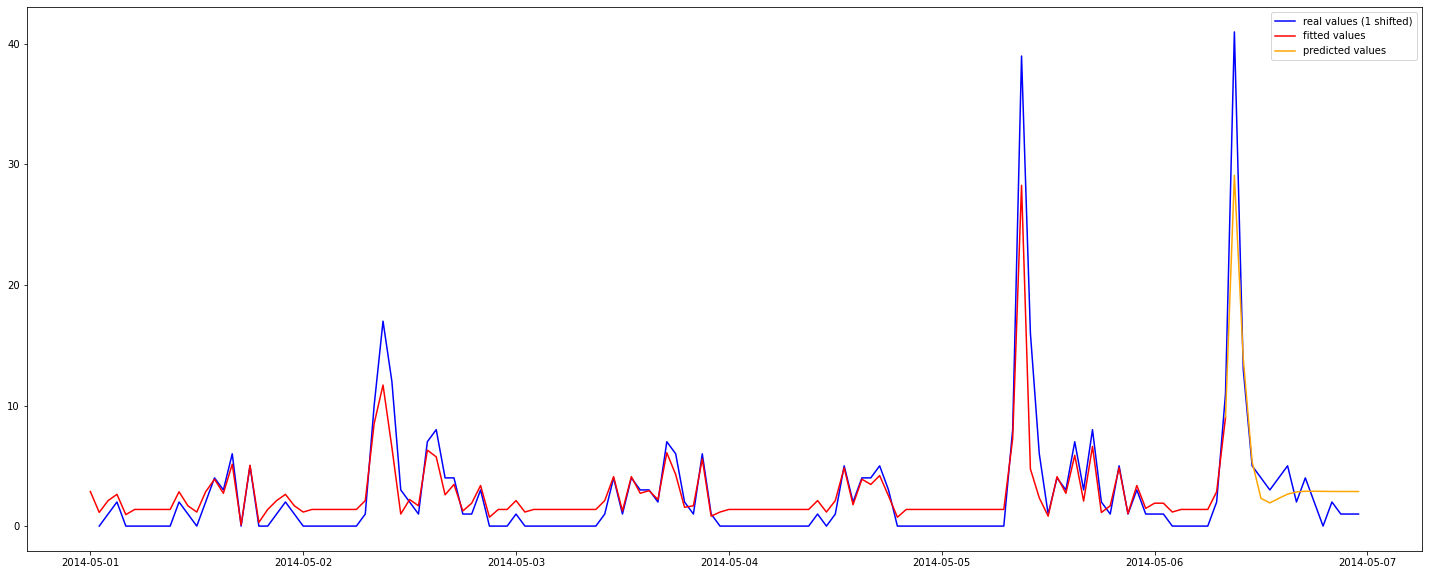

In [108]:
hourly_arima_predictions = hourly_arima_fit.predict(
    start=hourly_train.index.max(), end=hourly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    hourly_sample.loc[hourly_arima_predictions.index], hourly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(hourly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(hourly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(hourly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [109]:
hourly_sarimax = SARIMAX(hourly_train, order=hourly_order, seasonal_order=hourly_seasonal_order)
hourly_sarimax_fit = hourly_sarimax.fit()
hourly_sarimax_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          check_ins   No. Observations:                  129
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                -372.090
Date:                            Fri, 14 May 2021   AIC                            754.180
Time:                                    17:46:48   BIC                            768.479
Sample:                                05-01-2014   HQIC                           759.990
                                     - 05-06-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6500      0.060     10.921      0.000       0.533       0.767
ar.L2         -0.1062      0.183     -0.582      0.561      -0.464       0.252
ar.S.L24       0.6218      0.039     15.840      0.000       0.545       0.699
ar.S.L48      -0.1327      0.286     -0.464      0.643      -0.694       0.428
sigma2        17.3600      0.707     24.553      0.000      15.974      18.746
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              5776.28
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                             4.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 350135704677408.44


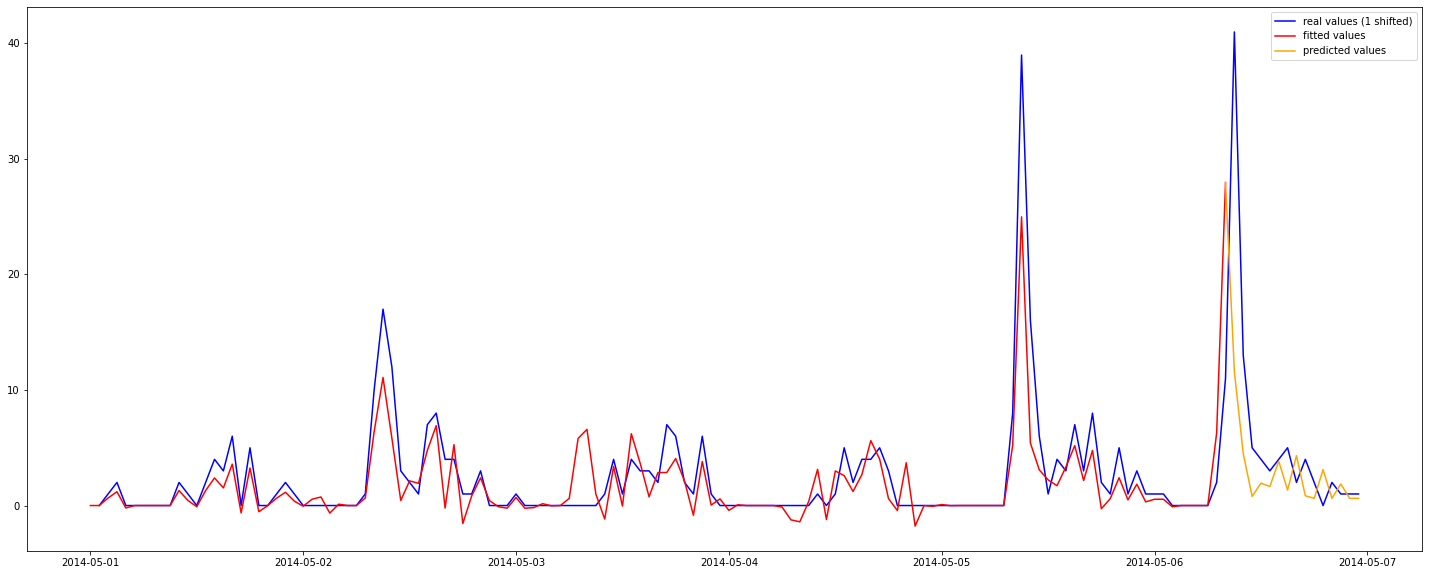

In [110]:
hourly_sarimax_predictions = hourly_sarimax_fit.predict(
    start=hourly_train.index.max(), end=hourly_test.index.max(), dynamic=True
).to_frame()
mape = mean_absolute_percentage_error(
    hourly_sample.loc[hourly_sarimax_predictions.index], hourly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(hourly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(hourly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(hourly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()